In [1]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import xgboost as xg
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

In [2]:
directory = r'D:\\Studies\\Projects\\DPS Project'
input_directory = os.path.join(directory, 'Original Datasets')
output_directory = os.path.join(directory, 'Feature Selected files')

csv_names = ['02-14-2018.csv', '02-15-2018.csv', '02-16-2018.csv', '02-20-2018.csv', 
            '02-21-2018.csv', '02-22-2018.csv', '02-23-2018.csv', '02-28-2018.csv', 
            '03-01-2018.csv', '03-02-2018.csv']

csv_list = []

for name in csv_names:
    csv_list.append(os.path.join(input_directory, name))

remove_cols = ['Label', 'Timestamp']
extra_cols = ['Flow ID', 'Src IP', 'Dst IP']

encoder = LabelEncoder()
imputer = SimpleImputer(strategy = 'mean')

In [3]:
def feature_selector(file_list):
    for idx, csv in enumerate(csv_list):
        print(f'CSV {idx}')
        df = pd.read_csv(csv)
        if idx == 3:
            X = df.drop(columns = remove_cols + extra_cols, axis = 1)
        else:
            X = df.drop(columns = remove_cols, axis = 1)
        original_feature_names = X.columns
        X = pd.DataFrame(X).apply(pd.to_numeric, errors='coerce').values

        print("Infinities in X:", np.isinf(X).sum())
        threshold = 1e+100
        print("Large values in X:", (np.abs(X) > threshold).sum())

        X[np.isinf(X)] = np.nan
        print("Infinities in X:", np.isinf(X).sum())
        print("Large values in X:", (np.abs(X) > threshold).sum())

        X = imputer.fit_transform(X)
        X = pd.DataFrame(X, columns=original_feature_names)

        y = df['Label']
        y = encoder.fit_transform(y)

        model = xg.XGBClassifier()
        model.fit(X, y)

        importance = model.get_booster().get_score(importance_type='weight')
        top_10_importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))
        importance_df = pd.DataFrame(list(top_10_importance.items()), columns=[f'Feature{idx}', f'Importance{idx}'])
        importance_df = importance_df.sort_values(by = f'Importance{idx}', ascending = False)
        file_name = f'File{idx}_XG.csv'
        importance_df.to_csv(os.path.join(output_directory, file_name),  index = False)
        importance_df.head()

        plt.figure(figsize=(10, 6))
        xg.plot_importance(model, importance_type='weight', max_num_features=15)
        plt.title('Top 15 Feature Importance')
        plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.show()

        del df, X, y, model, importance, importance_df
        gc.collect()

CSV 0
Infinities in X: 5371
Large values in X: 5371
Infinities in X: 0
Large values in X: 0


<Figure size 1000x600 with 0 Axes>

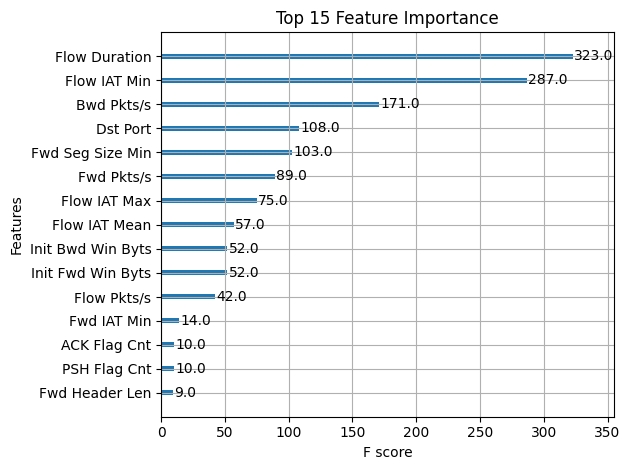

CSV 1
Infinities in X: 11133
Large values in X: 11133
Infinities in X: 0
Large values in X: 0


<Figure size 1000x600 with 0 Axes>

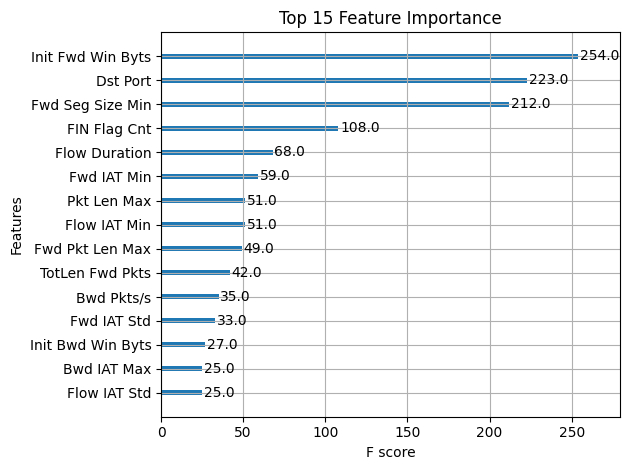

CSV 2
Infinities in X: 0
Large values in X: 0
Infinities in X: 0
Large values in X: 0


<Figure size 1000x600 with 0 Axes>

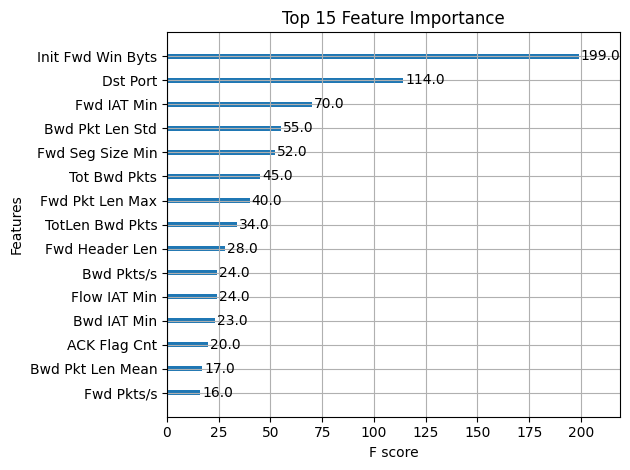

CSV 3
Infinities in X: 82139
Large values in X: 82139
Infinities in X: 0
Large values in X: 0


<Figure size 1000x600 with 0 Axes>

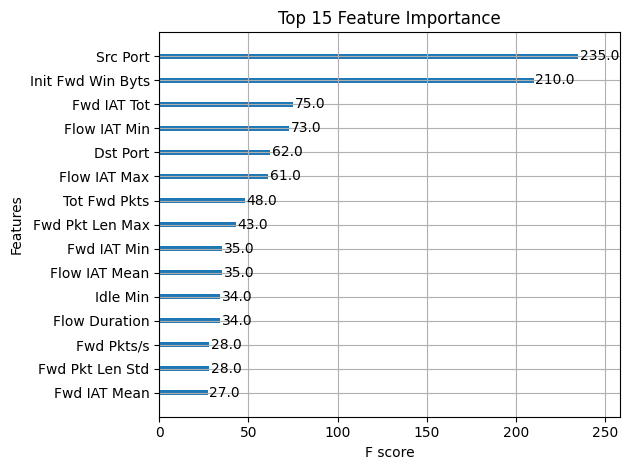

CSV 4
Infinities in X: 0
Large values in X: 0
Infinities in X: 0
Large values in X: 0


<Figure size 1000x600 with 0 Axes>

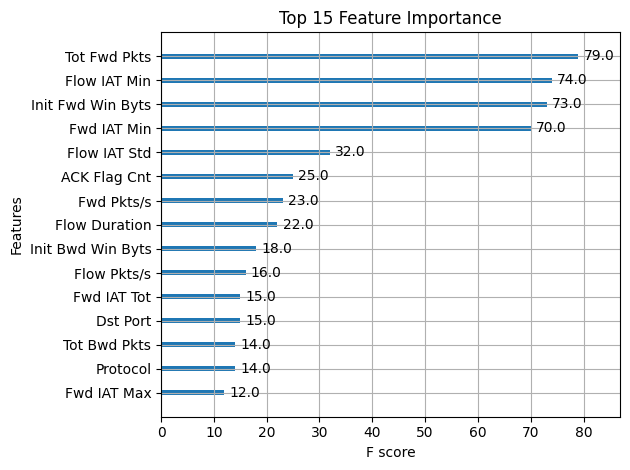

CSV 5
Infinities in X: 7651
Large values in X: 7651
Infinities in X: 0
Large values in X: 0


<Figure size 1000x600 with 0 Axes>

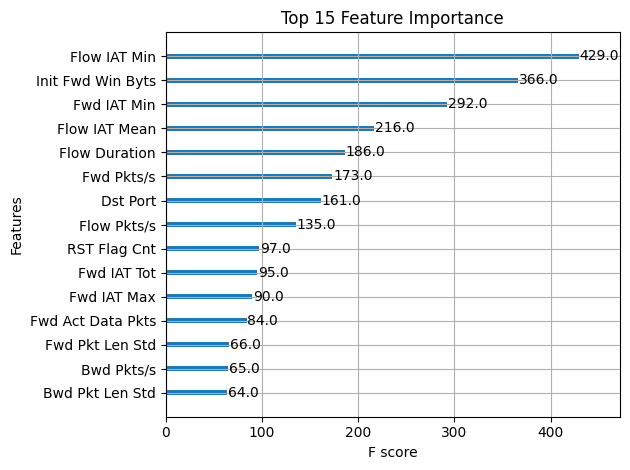

CSV 6
Infinities in X: 7662
Large values in X: 7662
Infinities in X: 0
Large values in X: 0


<Figure size 1000x600 with 0 Axes>

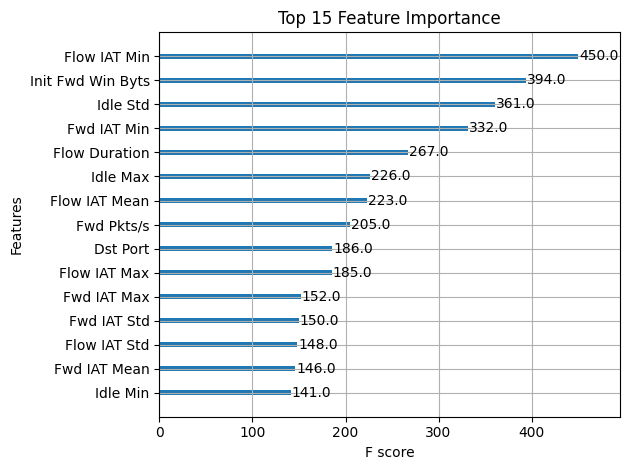

CSV 7
Infinities in X: 8297
Large values in X: 8297
Infinities in X: 0
Large values in X: 0


<Figure size 1000x600 with 0 Axes>

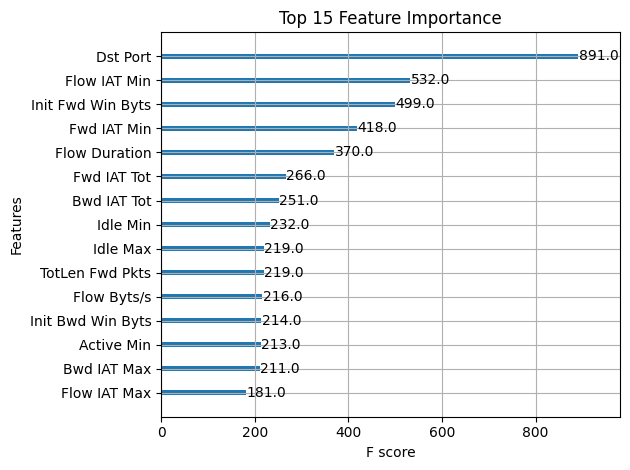

CSV 8
Infinities in X: 4004
Large values in X: 4004
Infinities in X: 0
Large values in X: 0


<Figure size 1000x600 with 0 Axes>

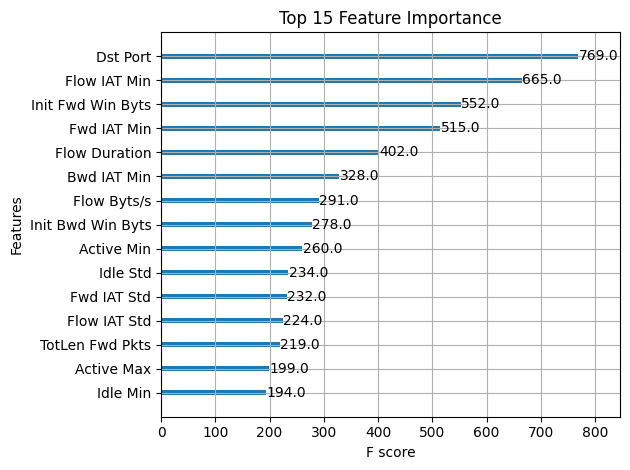

CSV 9
Infinities in X: 5542
Large values in X: 5542
Infinities in X: 0
Large values in X: 0


<Figure size 1000x600 with 0 Axes>

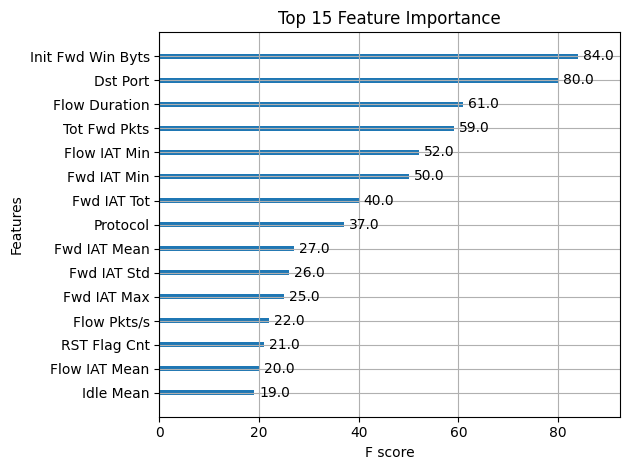

In [5]:
feature_selector(csv_list)

In [10]:
feature_directory = os.path.join(directory, 'Feature Selected files')
dfs = []
feature_csv = []

for i in range(10):  
    feature_csv.append(f"File{i}_XG.csv")

print(feature_csv)
    
for idx, file in enumerate(feature_csv): 
    df = pd.read_csv(os.path.join(feature_directory, file))
    df.columns = ['Feature', 'Importance']
    df['Notebook'] = f'Notebook_{idx}'
    dfs.append(df)

final_df = pd.concat(dfs, ignore_index=True)

grouped_df = final_df.groupby(['Feature', 'Notebook'], as_index=False).agg({'Importance': 'sum'})

grouped_df = grouped_df.sort_values(by='Importance', ascending=False)

feature_counts = final_df['Feature'].value_counts()

valid_features = feature_counts[feature_counts >= 9].index

filtered_df = grouped_df[grouped_df['Feature'].isin(valid_features)]

features_to_select = filtered_df['Feature'].unique().tolist()
features_to_select

['File0_XG.csv', 'File1_XG.csv', 'File2_XG.csv', 'File3_XG.csv', 'File4_XG.csv', 'File5_XG.csv', 'File6_XG.csv', 'File7_XG.csv', 'File8_XG.csv', 'File9_XG.csv']


['Dst Port',
 'Flow IAT Min',
 'Init Fwd Win Byts',
 'Fwd IAT Min',
 'Flow Duration',
 'Bwd IAT Min',
 'Flow Byts/s',
 'Init Bwd Win Byts',
 'Fwd IAT Tot',
 'Fwd IAT Std',
 'Flow IAT Std',
 'Flow IAT Mean',
 'Fwd Pkts/s',
 'Flow IAT Max',
 'Bwd Pkts/s',
 'Flow Pkts/s',
 'Fwd IAT Mean',
 'Fwd IAT Max',
 'Fwd Pkt Len Max',
 'Tot Fwd Pkts',
 'Fwd Header Len',
 'Fwd Act Data Pkts',
 'ACK Flag Cnt']

In [12]:
filtered_df['Feature'].value_counts()

Feature
Dst Port             10
Flow IAT Min         10
Fwd Act Data Pkts    10
Fwd Header Len       10
Fwd IAT Max          10
Flow Pkts/s          10
Flow IAT Max         10
Fwd Pkts/s           10
ACK Flag Cnt         10
Init Bwd Win Byts    10
Flow Duration        10
Fwd IAT Min          10
Init Fwd Win Byts    10
Fwd IAT Std           9
Flow IAT Std          9
Fwd IAT Tot           9
Flow Byts/s           9
Bwd Pkts/s            9
Bwd IAT Min           9
Fwd IAT Mean          9
Fwd Pkt Len Max       9
Tot Fwd Pkts          9
Flow IAT Mean         9
Name: count, dtype: int64